In [1]:
import torch
import kagglehub
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [2]:
# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis


In [3]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
count = 0

for root, dirs, files in os.walk(dataset_path):
    if count >= 10:
        break
    for file in files:
        if file.endswith(".png"):
            print("Rutas encontradas con las imagenes")
            print("-", os.path.join(root, file))
            count += 1
            if count >= 10:
                break

Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/428.0.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/41.7.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/654.5.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/604.7.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/740.0.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/188.3.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/541.8.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-com

In [4]:
train_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST", "train")
modalities = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
print("Modalidades encontradas:", modalities)

Modalidades encontradas: ['m4', 'm2', 'm0', 'm1', 'm3']


### Visualización de Imagenes en el Dataset


Modalidad: m4, mostrando 5 ejemplos...


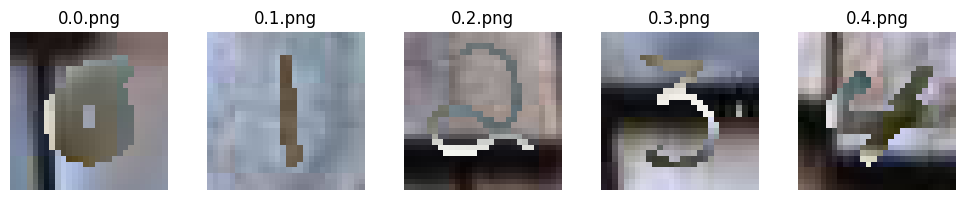


Modalidad: m2, mostrando 5 ejemplos...


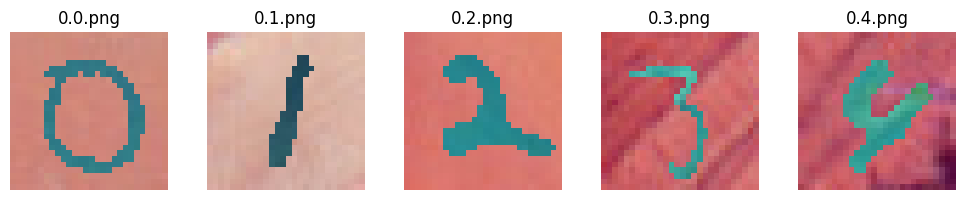


Modalidad: m0, mostrando 5 ejemplos...


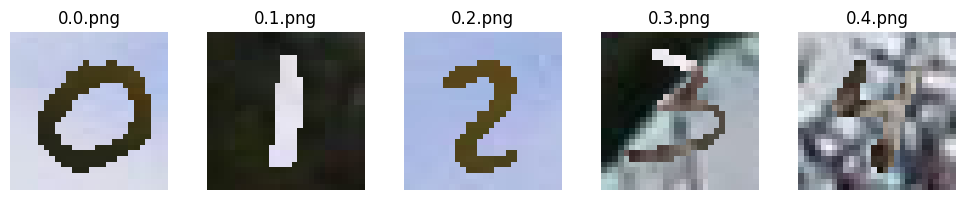


Modalidad: m1, mostrando 5 ejemplos...


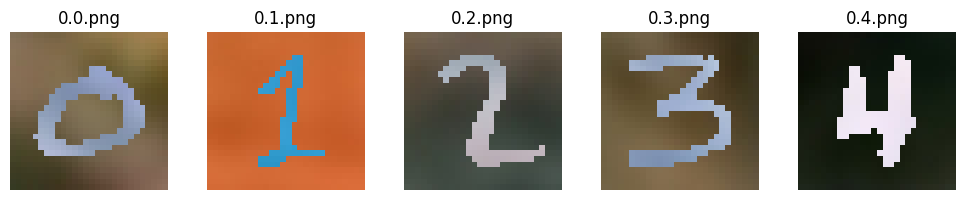


Modalidad: m3, mostrando 5 ejemplos...


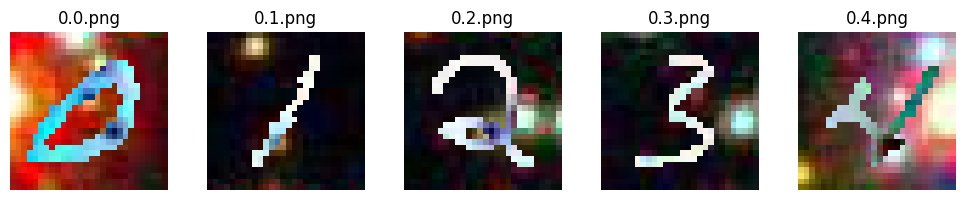

In [7]:
for modality in modalities:
    folder = os.path.join(train_path, modality)
    files = sorted([f for f in os.listdir(folder) if f.endswith(".png")])
    print(f"\nModalidad: {modality}, mostrando 5 ejemplos...")

    plt.figure(figsize=(10, 2))
    for i in range(5):
        img = Image.open(os.path.join(folder, files[i]))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(files[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### Análisis Exploratorio

In [8]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
base_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST")

data = []

for split in ["train", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        continue
    for modality in os.listdir(split_path):
        modality_path = os.path.join(split_path, modality)
        if not os.path.isdir(modality_path):
            continue
        for file in os.listdir(modality_path):
            if file.endswith(".png"):
                try:
                    label = int(file.split(".")[1])  # Ej: 1234.5.png → 5
                    full_path = os.path.join(modality_path, file)
                    data.append({
                        "file_path": full_path,
                        "label": label,
                        "modality": modality,
                        "split": split
                    })
                except Exception as e:
                    print(f"Error con archivo: {file} → {e}")

df = pd.DataFrame(data)
print("DataFrame generado con", len(df), "registros.")
print(df.head())

DataFrame generado con 350000 registros.
                                           file_path  label modality  split
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train


In [9]:
print("Total de imágenes:", len(df))
print("\nCantidad por conjunto:")
print(df['split'].value_counts())

print("\nCantidad por modalidad:")
print(df['modality'].value_counts())

print("\nEtiquetas únicas (clases):", sorted(df['label'].unique()))

Total de imágenes: 350000

Cantidad por conjunto:
split
train    300000
test      50000
Name: count, dtype: int64

Cantidad por modalidad:
modality
m4    70000
m2    70000
m0    70000
m1    70000
m3    70000
Name: count, dtype: int64

Etiquetas únicas (clases): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


In [10]:
img = Image.open(df['file_path'].iloc[0])
print("Tamaño:", img.size, "| Modo:", img.mode)

Tamaño: (28, 28) | Modo: RGB


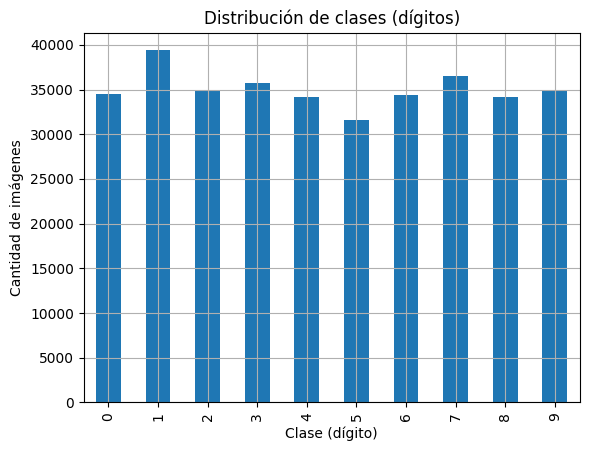

In [12]:
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de clases (dígitos)")
plt.xlabel("Clase (dígito)")
plt.ylabel("Cantidad de imágenes")
plt.grid(True)
plt.show()

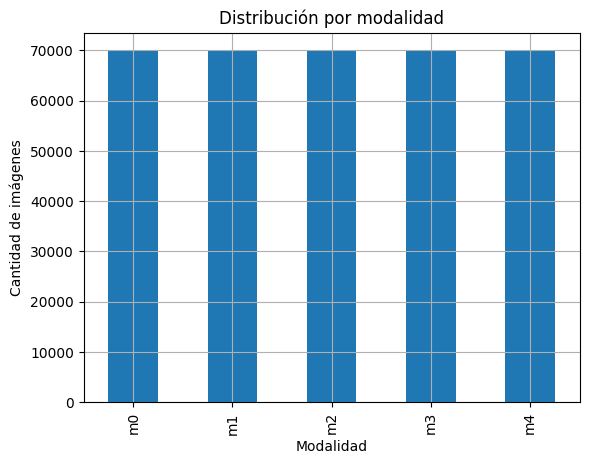

In [13]:
df['modality'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución por modalidad")
plt.xlabel("Modalidad")
plt.ylabel("Cantidad de imágenes")
plt.grid(True)
plt.show()

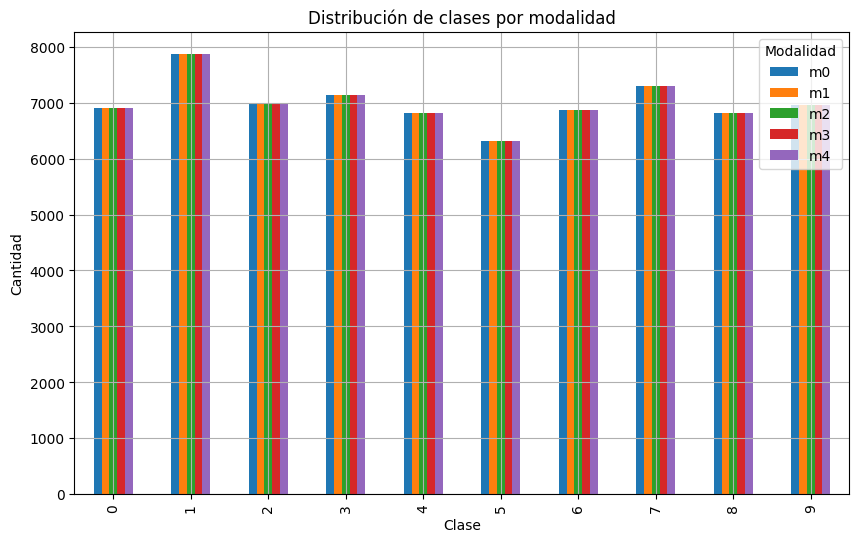

In [14]:
pivot = df.pivot_table(index='label', columns='modality', aggfunc='size', fill_value=0)
pivot.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title("Distribución de clases por modalidad")
plt.ylabel("Cantidad")
plt.xlabel("Clase")
plt.legend(title="Modalidad")
plt.grid(True)
plt.show()

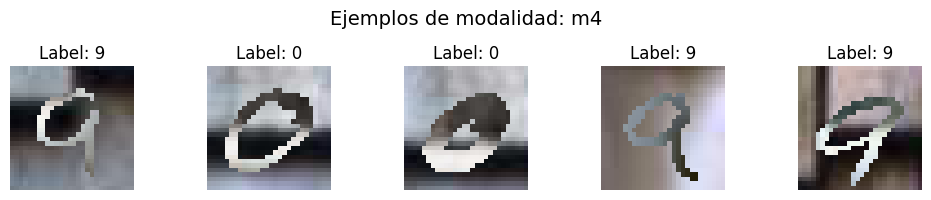

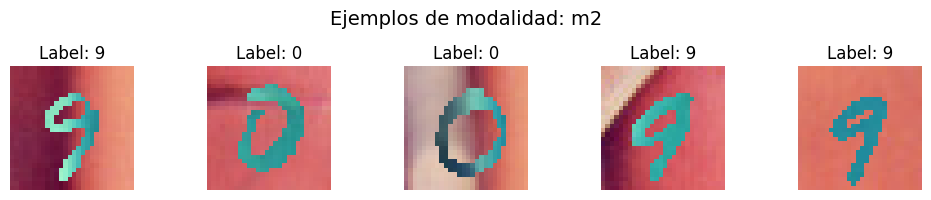

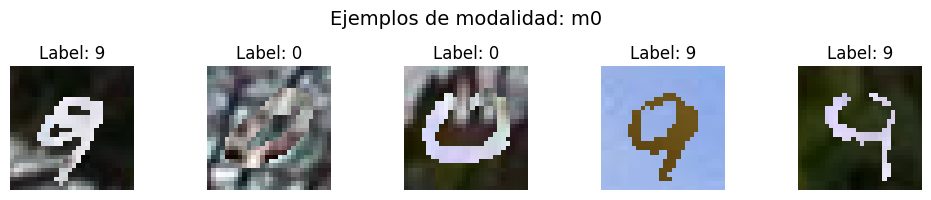

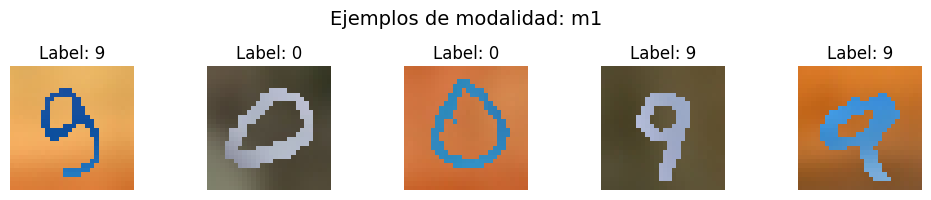

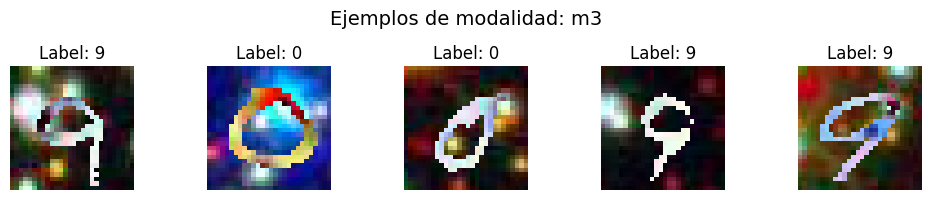

In [15]:
modalities = df['modality'].unique()

for modality in modalities:
    sample = df[(df['modality'] == modality) & (df['split'] == 'train')].head(5)

    plt.figure(figsize=(10, 2))
    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row['file_path'])
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {row['label']}")
        plt.axis("off")
    plt.suptitle(f"Ejemplos de modalidad: {modality}", fontsize=14)
    plt.tight_layout()
    plt.show()